In [1]:
import os
from os.path import join

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]='1'

In [3]:
from cam import CAM

In [4]:
import util

In [5]:
import dataloader

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [7]:
map = CAM()

In [8]:
class_dict = dataloader.get_class_dict('/data2/imagenet')[0]

In [9]:
data_dict = map.valid_dataset.data_dict

In [10]:
input_files = map.valid_dataset.img_files

In [11]:
img_dir = map.valid_dataset.img_dir

In [19]:
data_idx = 2
input_file = input_files[data_idx]
img_origin = Image.open(join(img_dir, input_file)).convert('RGB')

input, target = map.get_item(data_idx)
target = target.cpu().item()

topk_idxs = map.topk(input)
top1_correct = target in topk_idxs[:1]
top5_correct = target in topk_idxs[:5]
top5_classes = [class_dict[i.item()] for i in topk_idxs[:5]]
print(f"target: {target} which is '{class_dict[target]}' \n top-5: {topk_idxs[:5]} which is {top5_classes}")

target: 230 which is 'Shetland_sheepdog' 
 top-5: tensor([230, 231, 169, 157, 193], device='cuda:0') which is ['Shetland_sheepdog', 'collie', 'borzoi', 'papillon', 'Australian_terrier']


In [20]:
att_idx = target

# get true bbox
bboxes_true = data_dict[input_file][1]
bboxes_true = util.bboxes_resize(img_origin, bboxes_true, size=224)

In [21]:
# origin
img, heatmap_origin, boolmap, boolmap_biggest, \
bbox_pred = map.get_values(data_idx,att_idx, th1=0.2, phase='test')

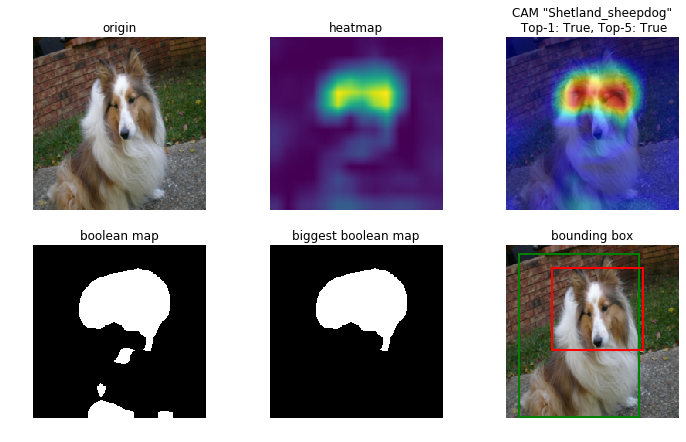

In [22]:
_, ax = plt.subplots(2,3,figsize=(12,7))

ax[0,0].imshow(img)
ax[0,0].set_title('origin')
ax[0,0].axis('off')

ax[0,1].imshow(heatmap_origin)
ax[0,1].set_title('heatmap')
ax[0,1].axis('off')

ax[0,2].imshow(img)
ax[0,2].imshow(heatmap_origin, alpha=0.5, cmap='jet')
ax[0,2].set_title(f'CAM "{class_dict[target]}"\n Top-1: {top1_correct}, Top-5: {top5_correct}')
ax[0,2].axis('off')

ax[1,0].imshow(Image.fromarray((boolmap*255).astype(np.uint8)), cmap='gray')
ax[1,0].set_title('boolean map')
ax[1,0].axis('off')

ax[1,1].imshow(Image.fromarray((boolmap_biggest*255).astype(np.uint8)), cmap='gray')
ax[1,1].set_title('biggest boolean map')
ax[1,1].axis('off')

ax[1,2].imshow(img)
for bbox_true in bboxes_true:
    rect_true = patches.Rectangle((bbox_true[0],bbox_true[1]),bbox_true[2],bbox_true[3],
                                  linewidth=2,edgecolor='g',facecolor='none')
    ax[1,2].add_patch(rect_true)
rect_pred = patches.Rectangle((bbox_pred[0],bbox_pred[1]),bbox_pred[2],bbox_pred[3],
                              linewidth=2,edgecolor='r',facecolor='none')
ax[1,2].add_patch(rect_pred)
ax[1,2].set_title('bounding box')
ax[1,2].axis('off')

plt.show()

In [28]:
# propose
_, heatmap_mean, heatmap_std, boolmap_propose, boolmap_biggest_propose, \
bbox_propose = map.get_values(data_idx, att_idx, th1=0.4, th2=0.3, mc=50, phase='train')

heatmap_std_max = heatmap_std.max()

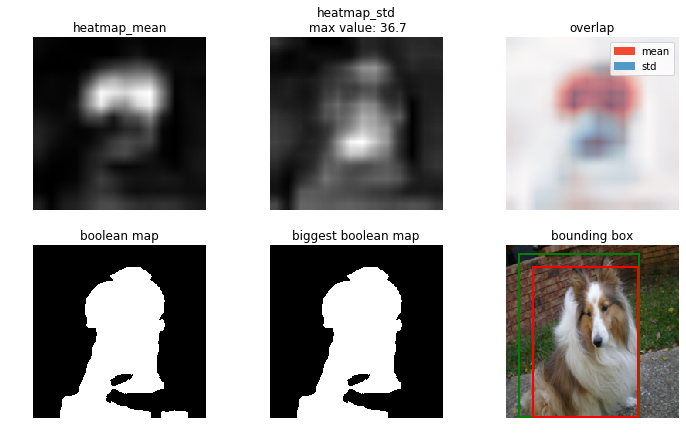

In [30]:
_, ax = plt.subplots(2,3,figsize=(12,7))
ax[0,0].imshow(heatmap_mean, cmap='gray')
ax[0,0].set_title('heatmap_mean')
ax[0,0].axis('off')

ax[0,1].imshow(heatmap_std, cmap='gray')
ax[0,1].set_title(f'heatmap_std\n max value: {heatmap_std_max:.01f}')
ax[0,1].axis('off')

im1 = ax[0,2].imshow(heatmap_mean, cmap='Reds', label='mean')
im2 = ax[0,2].imshow(heatmap_std, cmap='Blues', label='std', alpha=0.5)
ax[0,2].set_title('overlap')
ax[0,2].axis('off')
patch = [patches.Patch(color=im1.cmap(150), label='mean'), 
         patches.Patch(color=im2.cmap(150), label='std')]
ax[0,2].legend(handles=patch, loc='best')

ax[1,0].imshow(Image.fromarray((boolmap_propose*255).astype(np.uint8)), cmap='gray')
ax[1,0].set_title('boolean map')
ax[1,0].axis('off')

ax[1,1].imshow(Image.fromarray((boolmap_biggest_propose*255).astype(np.uint8)), cmap='gray')
ax[1,1].set_title('biggest boolean map')
ax[1,1].axis('off')

ax[1,2].imshow(img)
for bbox_true in bboxes_true:
    rect_true = patches.Rectangle((bbox_true[0],bbox_true[1]),bbox_true[2],bbox_true[3],
                                  linewidth=2,edgecolor='g',facecolor='none')
    ax[1,2].add_patch(rect_true)
rect_pred = patches.Rectangle((bbox_propose[0],bbox_propose[1]),bbox_propose[2],bbox_propose[3],
                              linewidth=2,edgecolor='r',facecolor='none')
ax[1,2].add_patch(rect_pred)
ax[1,2].set_title('bounding box')
ax[1,2].axis('off')

plt.show()

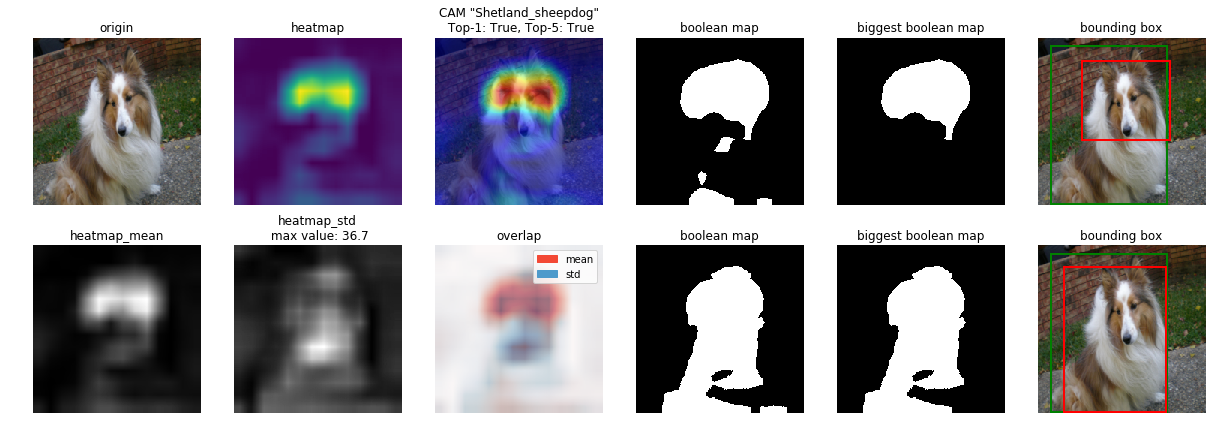

In [31]:
_, ax = plt.subplots(2,6,figsize=(21,7))

ax[0,0].imshow(img)
ax[0,0].set_title('origin')
ax[0,0].axis('off')

ax[0,1].imshow(heatmap_origin)
ax[0,1].set_title('heatmap')
ax[0,1].axis('off')

ax[0,2].imshow(img)
ax[0,2].imshow(heatmap_origin, alpha=0.5, cmap='jet')
ax[0,2].set_title(f'CAM "{class_dict[target]}"\n Top-1: {top1_correct}, Top-5: {top5_correct}')
ax[0,2].axis('off')

ax[0,3].imshow(Image.fromarray((boolmap*255).astype(np.uint8)), cmap='gray')
ax[0,3].set_title('boolean map')
ax[0,3].axis('off')

ax[0,4].imshow(Image.fromarray((boolmap_biggest*255).astype(np.uint8)), cmap='gray')
ax[0,4].set_title('biggest boolean map')
ax[0,4].axis('off')

ax[0,5].imshow(img)
for bbox_true in bboxes_true:
    rect_true = patches.Rectangle((bbox_true[0],bbox_true[1]),bbox_true[2],bbox_true[3],
                                  linewidth=2,edgecolor='g',facecolor='none')
    ax[0,5].add_patch(rect_true)
rect_pred = patches.Rectangle((bbox_pred[0],bbox_pred[1]),bbox_pred[2],bbox_pred[3],
                              linewidth=2,edgecolor='r',facecolor='none')
ax[0,5].add_patch(rect_pred)
ax[0,5].set_title('bounding box')
ax[0,5].axis('off')


ax[1,0].imshow(heatmap_mean, cmap='gray')
ax[1,0].set_title('heatmap_mean')
ax[1,0].axis('off')

ax[1,1].imshow(heatmap_std, cmap='gray')
ax[1,1].set_title(f'heatmap_std\n max value: {heatmap_std_max:.01f}')
ax[1,1].axis('off')

im1 = ax[1,2].imshow(heatmap_mean, cmap='Reds', label='mean')
im2 = ax[1,2].imshow(heatmap_std, cmap='Blues', label='std', alpha=0.5)
ax[1,2].set_title('overlap')
ax[1,2].axis('off')
patch = [patches.Patch(color=im1.cmap(150), label='mean'), 
         patches.Patch(color=im2.cmap(150), label='std')]
ax[1,2].legend(handles=patch, loc='best')

ax[1,3].imshow(Image.fromarray((boolmap_propose*255).astype(np.uint8)), cmap='gray')
ax[1,3].set_title('boolean map')
ax[1,3].axis('off')

ax[1,4].imshow(Image.fromarray((boolmap_biggest_propose*255).astype(np.uint8)), cmap='gray')
ax[1,4].set_title('biggest boolean map')
ax[1,4].axis('off')

ax[1,5].imshow(img)
for bbox_true in bboxes_true:
    rect_true = patches.Rectangle((bbox_true[0],bbox_true[1]),bbox_true[2],bbox_true[3],
                                  linewidth=2,edgecolor='g',facecolor='none')
    ax[1,5].add_patch(rect_true)
rect_pred = patches.Rectangle((bbox_propose[0],bbox_propose[1]),bbox_propose[2],bbox_propose[3],
                              linewidth=2,edgecolor='r',facecolor='none')
ax[1,5].add_patch(rect_pred)
ax[1,5].set_title('bounding box')
ax[1,5].axis('off')

plt.show()